<a href="https://colab.research.google.com/github/NiharikaAdigoppula/Fraud-Detection-system/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'paysim1' dataset.
Path to dataset files: /kaggle/input/paysim1


## Initial Data Exploration and Preprocessing

Perform initial data exploration, handle missing values, and convert categorical features if necessary, ensuring the dataset is ready for feature engineering.


In [ ]:
import pandas as pd
import os

# Load the dataset
df = pd.read_csv(os.path.join(path, 'PS_20174392719_1491204439457_log.csv'))

print("First 5 rows of the DataFrame:")
print(df.head())

print("\nConcise summary of the DataFrame:")
df.info()

print("\nMissing values in each column:")
print(df.isnull().sum())

First 5 rows of the DataFrame:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  

Concise summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
R


The next step is to convert the 'type' column, which is a categorical feature, into numerical format using one-hot encoding and then display the first 5 rows of the DataFrame to verify the changes.



In [ ]:
df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=True)

print("First 5 rows of the DataFrame after one-hot encoding:")
print(df.head())

First 5 rows of the DataFrame after one-hot encoding:
   step    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  \
0     1   9839.64  C1231006815       170136.0       160296.36  M1979787155   
1     1   1864.28  C1666544295        21249.0        19384.72  M2044282225   
2     1    181.00  C1305486145          181.0            0.00   C553264065   
3     1    181.00   C840083671          181.0            0.00    C38997010   
4     1  11668.14  C2048537720        41554.0        29885.86  M1230701703   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  type_CASH_OUT  \
0             0.0             0.0        0               0          False   
1             0.0             0.0        0               0          False   
2             0.0             0.0        1               0          False   
3         21182.0             0.0        1               0           True   
4             0.0             0.0        0               0          False   

   type_DEBIT 

## Feature Engineering

Create new features from transaction balances and amounts, such as difference in old and new balances for both origin and destination accounts, and error in balance after transaction.


In [ ]:
df['origBalance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['destBalance_diff'] = df['oldbalanceDest'] - df['newbalanceDest']
df['errorBalance_orig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalance_dest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

print("First 5 rows of the DataFrame after creating new features:")
print(df.head())

First 5 rows of the DataFrame after creating new features:
   step    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  \
0     1   9839.64  C1231006815       170136.0       160296.36  M1979787155   
1     1   1864.28  C1666544295        21249.0        19384.72  M2044282225   
2     1    181.00  C1305486145          181.0            0.00   C553264065   
3     1    181.00   C840083671          181.0            0.00    C38997010   
4     1  11668.14  C2048537720        41554.0        29885.86  M1230701703   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  type_CASH_OUT  \
0             0.0             0.0        0               0          False   
1             0.0             0.0        0               0          False   
2             0.0             0.0        1               0          False   
3         21182.0             0.0        1               0           True   
4             0.0             0.0        0               0          False   

   type_D

## Stratified Train-Test Split

Split the dataset into training and testing sets using a stratified split to maintain the original proportion of fraudulent transactions in both subsets.


In [ ]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'])
y = df['isFraud']
stratify=y

# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nProportion of fraud in y_train:", y_train.sum() / len(y_train))
print("Proportion of fraud in y_test:", y_test.sum() / len(y_test))

Shape of X_train: (4453834, 15)
Shape of X_test: (1908786, 15)
Shape of y_train: (4453834,)
Shape of y_test: (1908786,)

Proportion of fraud in y_train: 0.001290797995614565
Proportion of fraud in y_test: 0.001290872837499856


## Experiment with Imbalance Handling and Model Training

Train machine learning classifiers (e.g., LightGBM) by experimenting with two imbalance handling techniques: 1) applying class weighting to the model, and 2) using SMOTE on the training data before model training. Compare the performance of these approaches.


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# --- Approach 1: Class Weighting with LightGBM ---
print("\n--- Approach 1: Class Weighting with LightGBM ---")

# a. Calculate scale_pos_weight
neg_samples = y_train.value_counts()[0]
pos_samples = y_train.value_counts()[1]
scale_pos_weight = neg_samples / pos_samples

print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# b. Initialize LGBMClassifier with scale_pos_weight
model_cw = LGBMClassifier(
    objective='binary',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1 # Use all available cores
)

# c. Train the model
print("Training LGBMClassifier with class weighting...")
model_cw.fit(X_train, y_train)
print("Training complete.")

# d. Make probability predictions on X_test
y_pred_proba_cw = model_cw.predict_proba(X_test)[:, 1]

# e. Convert probabilities to binary predictions
y_pred_cw = (y_pred_proba_cw > 0.5).astype(int)

# f. Print evaluation metrics
print("\nClassification Report (Class Weighting):\n")
print(classification_report(y_test, y_pred_cw))
print(f"ROC AUC Score (Class Weighting): {roc_auc_score(y_test, y_pred_proba_cw):.4f}")


--- Approach 1: Class Weighting with LightGBM ---
Calculated scale_pos_weight: 773.71
Training LGBMClassifier with class weighting...
[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.297426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203
Training complete.

Classification Report (Class Weighting):

              precision    recall  f1-score   support

           0       1.00      0.86      0.93   1906322
           1       0.01      0.97      0.02      2464

    accuracy                           0.86   1908786
   macro avg       0.50      0.91      0.47   1908786
weighted avg       1.00      0.86 

In [ ]:
from imblearn.over_sampling import SMOTE

# --- Approach 2: SMOTE with LightGBM ---
print("\n--- Approach 2: SMOTE with LightGBM ---")

# b. Initialize SMOTE
smote = SMOTE(random_state=42)

# c. Apply SMOTE to the training data
print("Applying SMOTE to training data...")
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Shape of X_resampled: {X_resampled.shape}")
print(f"Shape of y_resampled: {y_resampled.shape}")
print(f"Proportion of fraud in y_resampled: {y_resampled.sum() / len(y_resampled)}")

# d. Initialize LGBMClassifier (without scale_pos_weight)
model_smote = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# e. Train the model
print("Training LGBMClassifier with SMOTE-resampled data...")
model_smote.fit(X_resampled, y_resampled)
print("Training complete.")

# f. Make probability predictions on X_test
y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# g. Convert probabilities to binary predictions
y_pred_smote = (y_pred_proba_smote > 0.5).astype(int)

# h. Print evaluation metrics
print("\nClassification Report (SMOTE):\n")
print(classification_report(y_test, y_pred_smote))
print(f"ROC AUC Score (SMOTE): {roc_auc_score(y_test, y_pred_proba_smote):.4f}")


--- Approach 2: SMOTE with LightGBM ---
Applying SMOTE to training data...
Shape of X_resampled: (8896170, 15)
Shape of y_resampled: (8896170,)
Proportion of fraud in y_resampled: 0.5
Training LGBMClassifier with SMOTE-resampled data...
[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.757578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training complete.

Classification Report (SMOTE):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.89      1.00      0.94      2464

    accuracy                           1.00   1908786
   macro avg       0.94      1.00      0.97   1

## Threshold Tuning and Evaluation

Tune the classification threshold for the best performing model to optimize precision and recall, specifically focusing on precision/recall@k. Generate and visualize relevant evaluation metrics such as Precision-Recall curves.



--- Threshold Tuning and Evaluation (SMOTE Model) ---


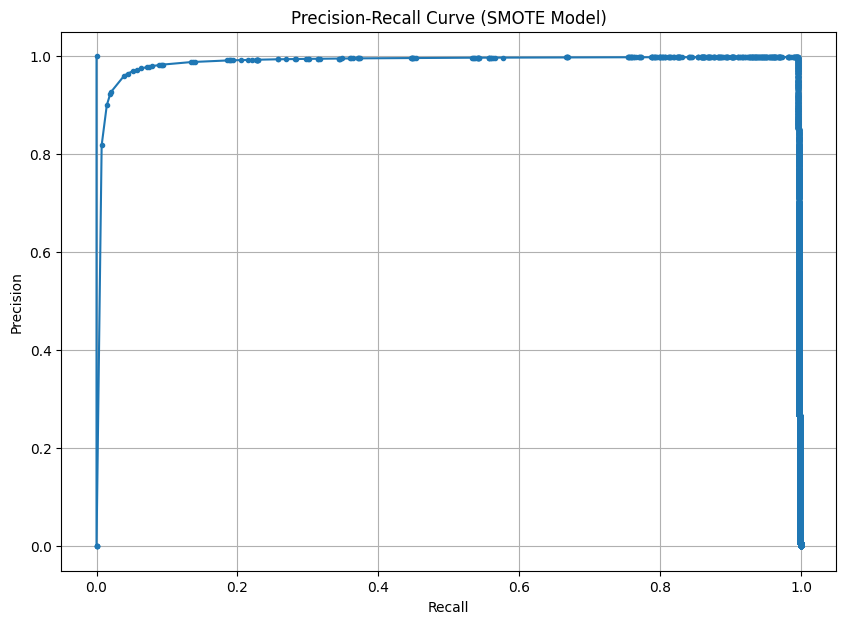

Best Threshold=0.9953, F1-Score=0.9972

Classification Report (SMOTE Model with Optimal Threshold (0.9953)):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC AUC Score (SMOTE Model with Optimal Threshold): 0.9997

--- Precision@k and Recall@k ---
k=100: Precision@100=0.9600, Recall@100=0.0390
k=500: Precision@500=0.9920, Recall@500=0.2013
k=1000: Precision@1000=0.9960, Recall@1000=0.4042
k=5000: Precision@5000=0.4916, Recall@5000=0.9976
k=10000: Precision@10000=0.2459, Recall@10000=0.9980


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported for np.divide

print("\n--- Threshold Tuning and Evaluation (SMOTE Model) ---")

# 1. Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_smote)

# 2. Plot the Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SMOTE Model)')
plt.grid(True)
plt.show()

# 3. Find the threshold that maximizes the F1-score
# Use np.divide to handle potential division by zero gracefully and avoid RuntimeWarning
fscore = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(precision), where=(precision + recall != 0))

ix = np.argmax(fscore)
# Ensure thresholds array is not empty before accessing ix
optimal_threshold = thresholds[ix] if len(thresholds) > 0 else 0.5 # Default to 0.5 if no thresholds
print(f'Best Threshold={optimal_threshold:.4f}, F1-Score={fscore[ix]:.4f}')

# 4. Apply the optimal threshold
y_pred_optimal = (y_pred_proba_smote >= optimal_threshold).astype(int)

# 5. Print the classification report and ROC AUC score with optimal threshold
from sklearn.metrics import classification_report, roc_auc_score
print(f"\nClassification Report (SMOTE Model with Optimal Threshold ({optimal_threshold:.4f})):\n")
print(classification_report(y_test, y_pred_optimal))
print(f"ROC AUC Score (SMOTE Model with Optimal Threshold): {roc_auc_score(y_test, y_pred_proba_smote):.4f}")

# 6. Calculate and print Precision@k and Recall@k
print("\n--- Precision@k and Recall@k ---")

def calculate_precision_recall_at_k(y_true, y_scores, k):
    # Sort predictions by score in descending order
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true.iloc[sorted_indices].reset_index(drop=True)

    # Select top k
    top_k_true = y_true_sorted.head(k)

    true_positives = top_k_true.sum()

    precision_at_k = true_positives / k if k > 0 else 0
    recall_at_k = true_positives / y_true.sum() if y_true.sum() > 0 else 0

    return precision_at_k, recall_at_k

# Define k values to evaluate
k_values = [100, 500, 1000, 5000, 10000]

for k in k_values:
    precision_at_k, recall_at_k = calculate_precision_recall_at_k(y_test, y_pred_proba_smote, k)
    print(f"k={k}: Precision@{k}={precision_at_k:.4f}, Recall@{k}={recall_at_k:.4f}")

## Export Fraud Scores


Predict fraud probabilities on the test set using the tuned model and export these 'fraud_score' probabilities along with transaction IDs to a CSV file.


In [ ]:
import pandas as pd

fraud_scores_df = pd.DataFrame({
    'transaction_id': X_test.index,
    'fraud_score': y_pred_proba_smote
})

print("First 5 rows of the fraud scores DataFrame:")
print(fraud_scores_df.head())

First 5 rows of the fraud scores DataFrame:
   transaction_id  fraud_score
0         1453282     0.000023
1         5338477     0.000025
2         2396500     0.000024
3         4577381     0.000023
4         2922798     0.000110


In [ ]:
fraud_scores_df.to_csv('fraud_score.csv', index=False)
print("Fraud scores exported to 'fraud_score.csv' successfully.")

Fraud scores exported to 'fraud_score.csv' successfully.


In [ ]:
import pandas as pd

print("Please enter the details for the new transaction:")

step = int(input("step (e.g., 1): "))
transaction_type = input("type (e.g., 'TRANSFER', 'PAYMENT', 'CASH_OUT', 'DEBIT', 'CASH_IN'): ")
amount = float(input("amount (e.g., 215310.3): "))
nameOrig = input("nameOrig (e.g., 'C729214703'): ")
oldbalanceOrg = float(input("oldbalanceOrg (e.g., 705.0): "))
newbalanceOrig = float(input("newbalanceOrig (e.g., 0.0): "))
nameDest = input("nameDest (e.g., 'C1387669462'): ")
oldbalanceDest = float(input("oldbalanceDest (e.g., 22425.0): "))
newbalanceDest = float(input("newbalanceDest (e.g., 0.0): "))
isFraud = int(input("isFraud (0 or 1, for reference, will be dropped): "))
isFlaggedFraud = int(input("isFlaggedFraud (0 or 1, for reference, will be dropped): "))


new_transaction_data_input = {
    'step': [step],
    'type': [transaction_type],
    'amount': [amount],
    'nameOrig': [nameOrig],
    'oldbalanceOrg': [oldbalanceOrg],
    'newbalanceOrig': [newbalanceOrig],
    'nameDest': [nameDest],
    'oldbalanceDest': [oldbalanceDest],
    'newbalanceDest': [newbalanceDest],
    'isFraud': [isFraud],
    'isFlaggedFraud': [isFlaggedFraud]
}

# Create the DataFrame
new_transaction_df = pd.DataFrame(new_transaction_data_input)

print("\nNew Transaction DataFrame from user input:")
print(new_transaction_df.head())


Please enter the details for the new transaction:
step (e.g., 1): 1
type (e.g., 'TRANSFER', 'PAYMENT', 'CASH_OUT', 'DEBIT', 'CASH_IN'): PAYMENT
amount (e.g., 215310.3): 215311.5
nameOrig (e.g., 'C729214703'): C729214615
oldbalanceOrg (e.g., 705.0): 703
newbalanceOrig (e.g., 0.0): 4695.0
nameDest (e.g., 'C1387669462'): C1387669463
oldbalanceDest (e.g., 22425.0): 100000
newbalanceDest (e.g., 0.0): 1004695
isFraud (0 or 1, for reference, will be dropped): 1
isFlaggedFraud (0 or 1, for reference, will be dropped): 1

New Transaction DataFrame from user input:
   step     type    amount    nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  PAYMENT  215311.5  C729214615          703.0          4695.0   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  C1387669463        100000.0       1004695.0        1               1  


## Preprocess New Transaction


Apply the same preprocessing steps (one-hot encoding for 'type' and creation of engineered features) to the new transaction DataFrame that were applied to the training data. Ensure the column order matches the training data features (`X_train`) for correct model inference.


In [ ]:
import pandas as pd
import numpy as np

# Assuming new_transaction_df is available from the previous user input cell
# Assuming X_train is available from previous data splitting cell

# 1. One-hot encode the 'type' column
new_transaction_encoded = pd.get_dummies(new_transaction_df, columns=['type'], prefix='type')

# 2. Ensure all type columns from X_train are present in new_transaction_encoded, fill missing with False
# These are the columns generated by pd.get_dummies from the 'type' column in the original dataset, excluding the one dropped by drop_first=True
expected_type_cols = ['type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
for col in expected_type_cols:
    if col not in new_transaction_encoded.columns:
        new_transaction_encoded[col] = False

# 3. Drop the original 'type' column if it still exists and is not one-hot encoded
# (pd.get_dummies usually drops it, but a check is good practice)
if 'type' in new_transaction_encoded.columns:
    new_transaction_encoded = new_transaction_encoded.drop(columns=['type'])

# 4. Feature Engineering - create balance difference and error features
new_transaction_encoded['origBalance_diff'] = new_transaction_encoded['oldbalanceOrg'] - new_transaction_encoded['newbalanceOrig']
new_transaction_encoded['destBalance_diff'] = new_transaction_encoded['oldbalanceDest'] - new_transaction_encoded['newbalanceDest']
# Ensure these calculations handle potential float conversion correctly from user input
new_transaction_encoded['errorBalance_orig'] = new_transaction_encoded['newbalanceOrig'] + new_transaction_encoded['amount'] - new_transaction_encoded['oldbalanceOrg']
new_transaction_encoded['errorBalance_dest'] = new_transaction_encoded['oldbalanceDest'] + new_transaction_encoded['amount'] - new_transaction_encoded['newbalanceDest']

# 5. Drop columns not used by the model ('isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest')
columns_to_drop = ['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest']
# Only drop columns that exist in the DataFrame
new_transaction_processed = new_transaction_encoded.drop(columns=[col for col in columns_to_drop if col in new_transaction_encoded.columns])

# 6. Align column order with X_train
expected_columns = X_train.columns.tolist() # X_train is available from the kernel state

# Create a new DataFrame with all expected columns, filling missing ones with 0 or False
# Initialize with NaNs to correctly handle dtypes before filling
new_transaction_final = pd.DataFrame(index=new_transaction_processed.index)
for col in expected_columns:
    if col in new_transaction_processed.columns:
        new_transaction_final[col] = new_transaction_processed[col]
    else:
        # Determine appropriate fill value based on expected dtype from X_train
        if col in X_train.columns and pd.api.types.is_bool_dtype(X_train[col]):
            new_transaction_final[col] = False
        else:
            new_transaction_final[col] = 0

# Ensure dtypes match X_train
for col in new_transaction_final.columns:
    if col in X_train.columns:
        # Convert if necessary, handling cases where X_train has bool but new_transaction_final has object (from False assignment)
        if pd.api.types.is_bool_dtype(X_train[col]) and not pd.api.types.is_bool_dtype(new_transaction_final[col]):
            new_transaction_final[col] = new_transaction_final[col].astype(bool)
        elif not pd.api.types.is_numeric_dtype(new_transaction_final[col]) and pd.api.types.is_numeric_dtype(X_train[col]):
            new_transaction_final[col] = pd.to_numeric(new_transaction_final[col], errors='coerce')
        new_transaction_final[col] = new_transaction_final[col].astype(X_train[col].dtype)


# 7. Print the head of the final preprocessed DataFrame
print("\nFinal Preprocessed New Transaction DataFrame:")
print(new_transaction_final.head())
print("\nColumn names and order of processed new transaction:")
print(new_transaction_final.columns.tolist())
print("\nColumn names and order of X_train:")
print(X_train.columns.tolist())


Final Preprocessed New Transaction DataFrame:
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1  215311.5          703.0          4695.0        100000.0   

   newbalanceDest  isFlaggedFraud  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
0       1004695.0               0          False       False          True   

   type_TRANSFER  origBalance_diff  destBalance_diff  errorBalance_orig  \
0          False           -3992.0         -904695.0           219303.5   

   errorBalance_dest  
0          -689383.5  

Column names and order of processed new transaction:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'origBalance_diff', 'destBalance_diff', 'errorBalance_orig', 'errorBalance_dest']

Column names and order of X_train:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH

In [ ]:
fraud_probability = model_smote.predict_proba(new_transaction_final)[:, 1]

print(f"Predicted fraud probability for the new transaction: {fraud_probability[0]:.4f}")

Predicted fraud probability for the new transaction: 0.0000


## Predict Fraud for New Transaction

Use the best performing model (SMOTE with LightGBM) to predict the fraud probability for the preprocessed new transaction. Display the raw probability and a binary classification based on the previously determined optimal threshold.


In [ ]:
print(f"Raw predicted fraud probability: {fraud_probability[0]:.4f}")

binary_prediction = (fraud_probability[0] >= optimal_threshold).astype(int)

if binary_prediction == 1:
    print(f"Classification (using optimal threshold {optimal_threshold:.4f}): Fraudulent")
else:
    print(f"Classification (using optimal threshold {optimal_threshold:.4f}): Not Fraudulent")

Raw predicted fraud probability: 0.0000
Classification (using optimal threshold 0.9953): Not Fraudulent
